In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import xgboost as xgb, lightgbm as lgbm, catboost as catb

from catboost import cv, Pool


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import featuretools as ft
import featuretools.variable_types as vtypes

import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('./course_project_train.csv', encoding='utf-8')
#X_test = pd.read_csv('./course_project_test.csv', encoding='utf-8')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

1. Обзор датасета

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [6]:
target = 'Credit Default'
cat_features = ['Home Ownership','Years in current job','Purpose','Term']
num_features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit','Number of Credit Problems',
                'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']


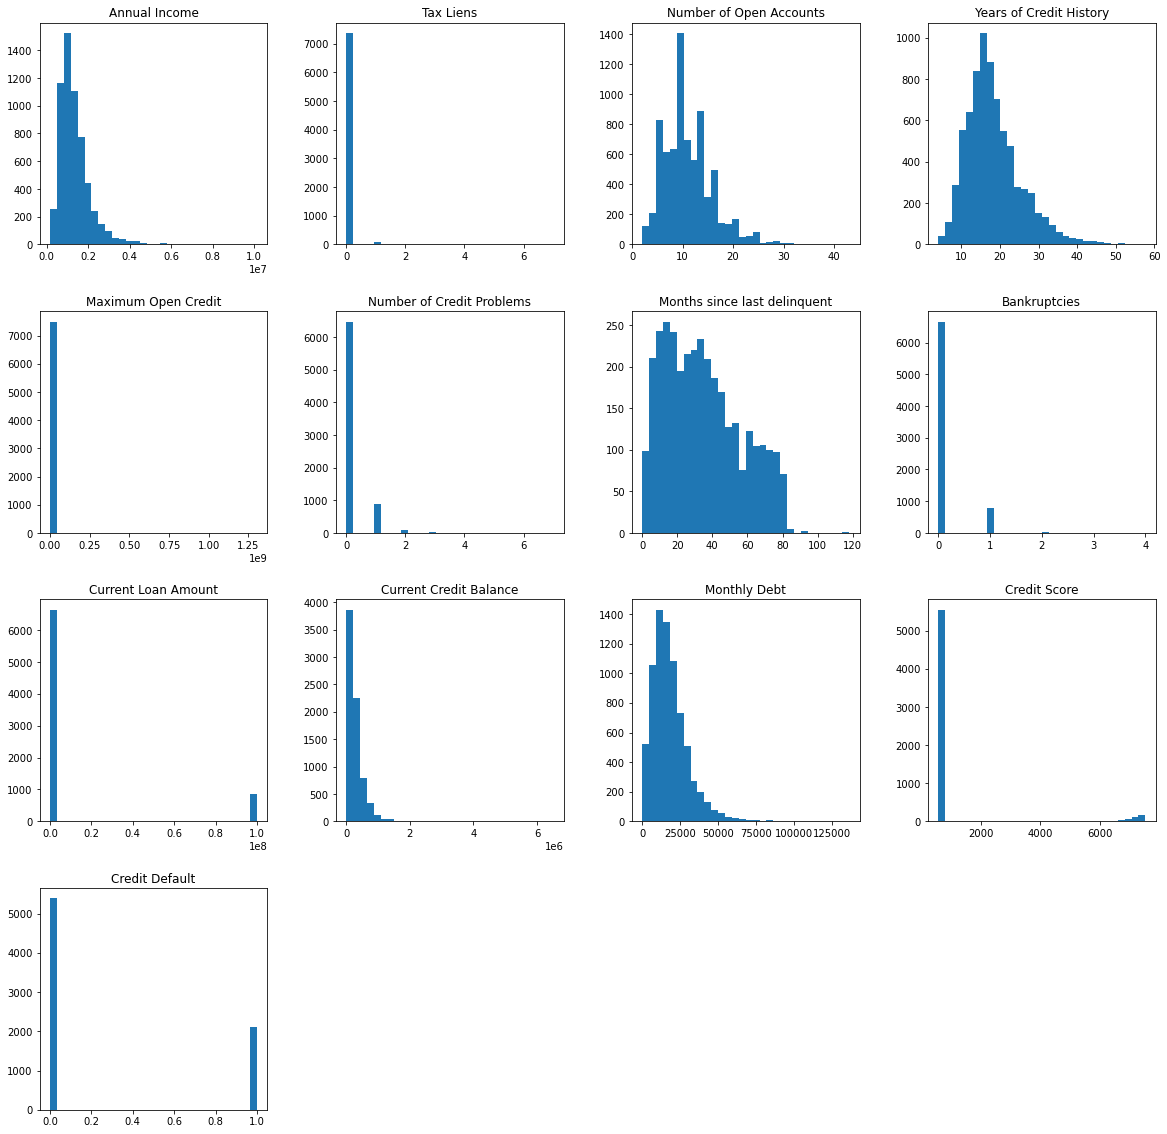

In [7]:
df.hist(figsize=(20,20), bins=30, grid=False);

На гистограмме показывающей кредитный скор виден выброс 

In [8]:
df.loc[df['Credit Score'] > 800, 'Credit Score'] /= 10

Уберем лишний знак у кредитного скоринга 

In [9]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,720.086993,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,27.957233,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,708.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,729.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,1.000000


In [10]:
len(df) - df.count() ### Посмотрим на пропуски в данных

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [11]:
df = df.drop(['Months since last delinquent'], axis=1) ### необходимо удалить признак так как у него очень много пропусков

In [12]:
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)

In [13]:
df.drop(df.loc[(df['Annual Income'].isna()) &(df['Credit Score'].isna())].index, inplace=True)

In [14]:
df.loc[(df['Years in current job'].isna())] 

df['Years in current job'].fillna(df['Years in current job'].mode().values[0], inplace = True)

In [15]:
len(df) - df.count() ### Annual Income и Credit Score оставим

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

In [16]:
X = df.drop('Credit Default', axis=1)
y = df['Credit Default']

In [17]:
es = ft.EntitySet(id='Credits')
es

Entityset: Credits
  Entities:
  Relationships:
    No relationships

In [18]:
X['Id'] = X.index

In [19]:
cols = num_features + cat_features
es.entity_from_dataframe(entity_id='Clients',
                         dataframe=X[cols],
                         index='Id')

/opt/conda/lib/python3.8/site-packages/featuretools/entityset/entity.py:462: UserWarning: index Id not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


Entityset: Credits
  Entities:
    Clients [Rows: 5943, Columns: 16]
  Relationships:
    No relationships

In [20]:
es["Clients"].variables

[<Variable: Id (dtype = index)>,
 <Variable: Annual Income (dtype = numeric)>,
 <Variable: Tax Liens (dtype = numeric)>,
 <Variable: Number of Open Accounts (dtype = numeric)>,
 <Variable: Years of Credit History (dtype = numeric)>,
 <Variable: Maximum Open Credit (dtype = numeric)>,
 <Variable: Number of Credit Problems (dtype = numeric)>,
 <Variable: Bankruptcies (dtype = numeric)>,
 <Variable: Current Loan Amount (dtype = numeric)>,
 <Variable: Current Credit Balance (dtype = numeric)>,
 <Variable: Monthly Debt (dtype = numeric)>,
 <Variable: Credit Score (dtype = numeric)>,
 <Variable: Home Ownership (dtype = categorical)>,
 <Variable: Years in current job (dtype = categorical)>,
 <Variable: Purpose (dtype = categorical)>,
 <Variable: Term (dtype = categorical)>]

In [21]:
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Annual Income', index='Annual Income')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Tax Liens', index='Tax Liens')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Number of Open Accounts', index='Number of Open Accounts')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Years of Credit History', index='Years of Credit History')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Maximum Open Credit', index='Maximum Open Credit')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Number of Credit Problems', index='Number of Credit Problems')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Bankruptcies', index='Bankruptcies')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Current Loan Amount', index='Current Loan Amount')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Monthly Debt', index='Monthly Debt')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Credit Score', index='Credit Score')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Home Ownership', index='Home Ownership')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Years in current job', index='Years in current job')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Purpose', index='Purpose')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Term', index='Term')

es

Entityset: Credits
  Entities:
    Clients [Rows: 5943, Columns: 16]
    Annual Income [Rows: 5478, Columns: 1]
    Tax Liens [Rows: 8, Columns: 1]
    Number of Open Accounts [Rows: 39, Columns: 1]
    Years of Credit History [Rows: 393, Columns: 1]
    Maximum Open Credit [Rows: 5587, Columns: 1]
    Number of Credit Problems [Rows: 8, Columns: 1]
    Bankruptcies [Rows: 5, Columns: 1]
    Current Loan Amount [Rows: 4311, Columns: 1]
    Monthly Debt [Rows: 5431, Columns: 1]
    Credit Score [Rows: 160, Columns: 1]
    Home Ownership [Rows: 4, Columns: 1]
    Years in current job [Rows: 11, Columns: 1]
    Purpose [Rows: 14, Columns: 1]
    Term [Rows: 2, Columns: 1]
  Relationships:
    Clients.Annual Income -> Annual Income.Annual Income
    Clients.Tax Liens -> Tax Liens.Tax Liens
    Clients.Number of Open Accounts -> Number of Open Accounts.Number of Open Accounts
    Clients.Years of Credit History -> Years of Credit History.Years of Credit History
    Clients.Maximum Open Cred

In [22]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity ='Clients',
                                       verbose=3, 
                                       n_jobs=-1)

Built 477 features
EntitySet scattered to 2 workers in 2 seconds
Elapsed: 00:36 | Progress: 100%|██████████


In [68]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [69]:
train_featured = feature_matrix_enc.copy()
train_featured.shape

(5943, 1411)

In [70]:
X = pd.get_dummies(train_featured)

In [71]:
y.value_counts()

0    4359
1    1584
Name: Credit Default, dtype: int64

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [73]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0.0    3063
1.0    2194
Name: Credit Default, dtype: int64

In [74]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

In [75]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [76]:
train.shape

(7120, 1412)

In [77]:
train[target].value_counts()

0.0    3063
1.0    2194
Name: Credit Default, dtype: int64

In [79]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoostError: catboost/private/libs/target/target_converter.cpp:394: NaN values are not supported for target

In [34]:
params = {'n_estimators':np.arange(20, 800, 5),
          'max_depth':np.arange(2, 10, 1),
          'learning_rate':np.arange(0.01, 0.1, 0.001),
          'l2_leaf_reg':np.arange(1, 10, 0.1)
         }

In [35]:
cv=KFold(n_splits=4, random_state=21, shuffle=True)

In [36]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

/opt/conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 12.6 s, sys: 932 ms, total: 13.6 s
Wall time: 4min 45s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fddd4260790>,
                   n_jobs=-1,
                   param_distributions={'l2_leaf_reg': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1...
       345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405,
       410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470,
       475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535,
       540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600,
       605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665,
       670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730,
       735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795])},
      

In [37]:
rs.best_params_

{'n_estimators': 425,
 'max_depth': 5,
 'learning_rate': 0.09799999999999992,
 'l2_leaf_reg': 5.200000000000004}

In [38]:
rs.best_score_

0.22514888440920322

In [67]:
%%time

final_model = catb.CatBoostClassifier(#class_weights=[1, 2],
                                      n_estimators=425, max_depth=5,
                                      learning_rate=0.098, l2_leaf_reg=5.2,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3063
           1       1.00      0.69      0.82      1097

    accuracy                           0.92      4160
   macro avg       0.95      0.85      0.88      4160
weighted avg       0.93      0.92      0.91      4160

TEST

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1296
           1       0.47      0.17      0.25       487

    accuracy                           0.72      1783
   macro avg       0.61      0.55      0.54      1783
weighted avg       0.67      0.72      0.67      1783

CONFUSION MATRIX

col_0              0   1
Credit Default          
0               1202  94
1                405  82
CPU times: user 11.1 s, sys: 562 ms, total: 11.6 s
Wall time: 7.77 s


<ipython-input-40-7cce6b88983b>:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


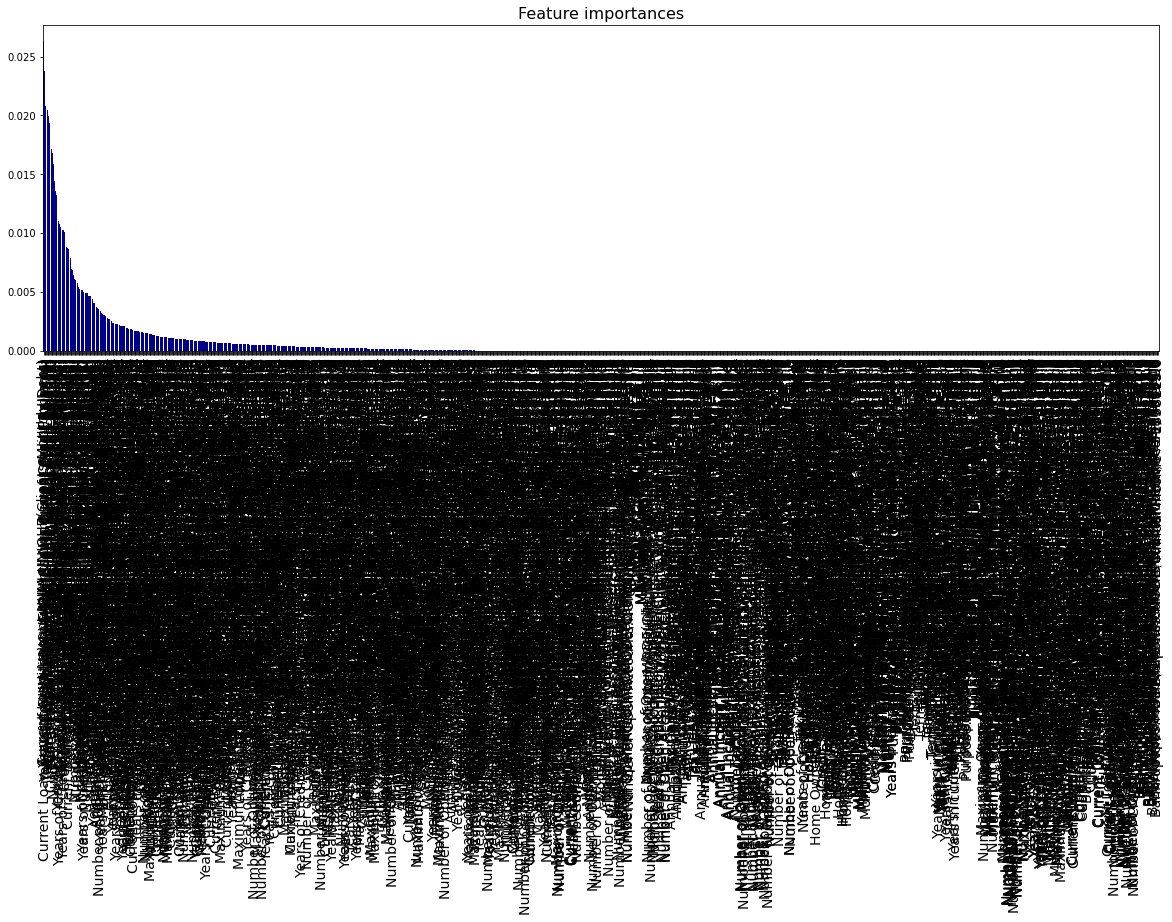

In [40]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = final_model.feature_importances_, X=X)

In [41]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_ / final_model.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [54]:
feature = feature_importances[feature_importances['importance'] == 0]

In [57]:
zero_features = feature['feature_name']